# Genentech Cervical Cancer Screening - Insights

https://www.kaggle.com/c/cervical-cancer-screening/

Cervical cancer is the third most common cancer in women worldwide, affecting over 500,000 women and resulting in approximately 275,000 deaths every year. Most women in the US have access to cervical cancer screening, yet 4,000 women die every year from cervical cancer in the US and it is estimated that 30% of US women do not receive regular pap screenings. 

Prior research suggests that lower screening rates are associated with low income, low education, lack of interaction with the healthcare system, and lack of health insurance. But research also shows that even in women with access to healthcare fail to get this preventive test, indicating that barriers like lack of education and not being comfortable with the procedure are influencing their behavior.

If one could better identify women who are not being screened, education campaigns could target them with content that speaks directly to their unique risk factors. Identifying predictors of not receiving pap smears will provide important information to stakeholders in cervical cancer prevention who run awareness programs.

### The goal is to predict which women will not be screened for cervical cancer on the recommended schedule.

Below is one analysis for the [Kaggle Genentech Cervical Cancer Screening](https://www.kaggle.com/c/cervical-cancer-screening/) competition.  Supporting files can be found in this [github repo](https://github.com/paulperry/kaggle-cervical-cancer-screening).

- By Paul Perry, Elena Cuoco, and Zygmunt Zając.

## Load 

This notebook is almost runnable in Kaggle scripts, but some feature extractions would take too long, and we make use of geopandas for mapping functions.  We use Postgres, but it would be easily swappable for Kaggle's sqlite3.

In [1]:
# imports
import sys # for stderr
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# settings 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
# pd.option.display.max_rows = 50
# pd.option.display.max_columns = 50

In [5]:
# versions 
import sys
print(pd.datetime.now())
print('Python: '+sys.version)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+skl.__version__)

2016-02-13 00:03:10.737227
Python: 2.7.11 |Anaconda 2.4.0 (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]
numpy: 1.10.2
pandas: 0.17.1
sklearn: 0.17


In [6]:
# if running in Kaggle scripts
# import sqlite3
# db = sqlite3.connect('../input/database.sqlite')

In [7]:
# if running locally with Postgres
import psycopg2
db = psycopg2.connect("dbname='ccancer' user='' host='localhost' password=''")

In [8]:
import datetime
start = datetime.datetime.now()
print(start)

2016-02-13 00:03:24.257033


In [9]:
train = pd.read_sql_query('select * from patients_train;', db)
train.set_index('patient_id', inplace=True)
train.drop('patient_gender', axis = 1, inplace = True )
print(train.shape)

(1157817, 6)


## Overall screening percentage

The average screening of patients overall is 55%:

In [10]:
train.is_screener.mean()

0.5577850385682711

## Screening by Age, Ethnicity, Household income, and Education level

At a high level, younger patients have a higher likelihood of being screened, and while a higher household income has a higher likelihood of being screened, ethnicity and education level are not distinguishing features at the overall aggregate level.

In [11]:
age = pd.DataFrame([train.groupby('patient_age_group').is_screener.count(),
                    train.groupby('patient_age_group').is_screener.mean()])
age = age.T
age.columns = ['count','screened']

/Users/paulperry/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


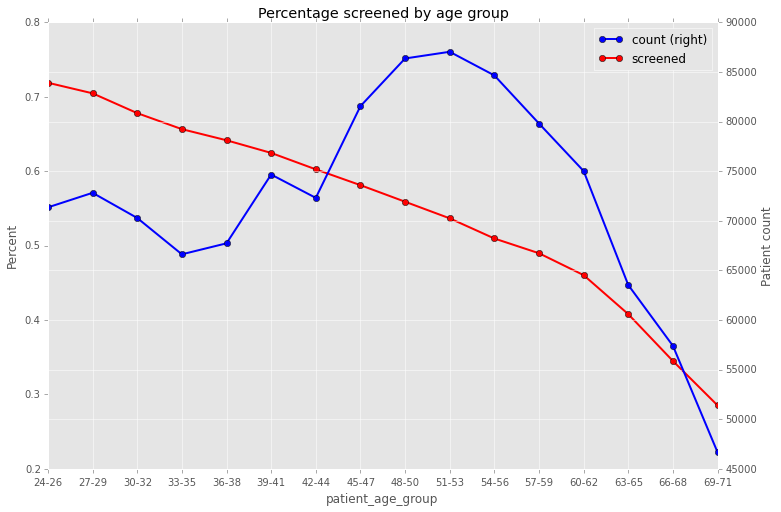

In [12]:
ax = age.plot( sharex=True, secondary_y='count', 
              title='Percentage screened by age group', marker='o', lw=2, colors=['blue','red'])
ax.set_ylabel('Percent')
ax.right_ax.set_ylabel('Patient count')
ax.set_xticks(range(len(age.index)))
ax.set_xticklabels(list(age.index))
ax.xaxis.grid(True)
plt.show()

Screen percentages by ethnicity, household income, and education level:

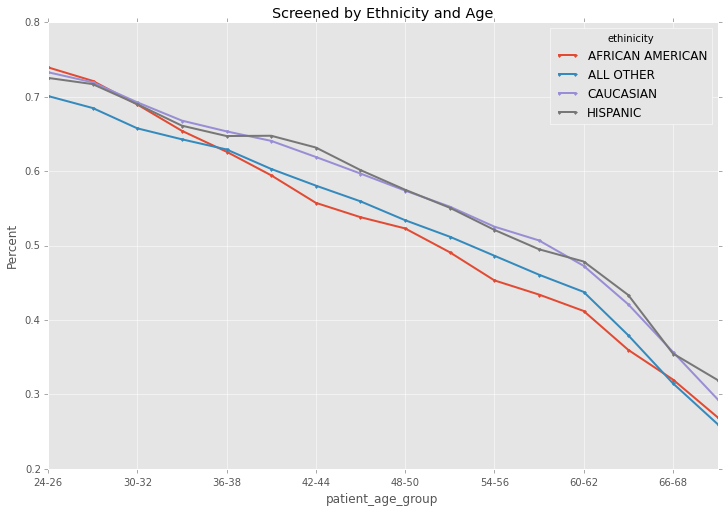

In [13]:
ax = train.groupby(['ethinicity','patient_age_group']).is_screener.mean().unstack().T.plot(lw=2, marker='.')
ax.set_ylabel('Percent')
ax.set_title('Screened by Ethnicity and Age')
plt.show()

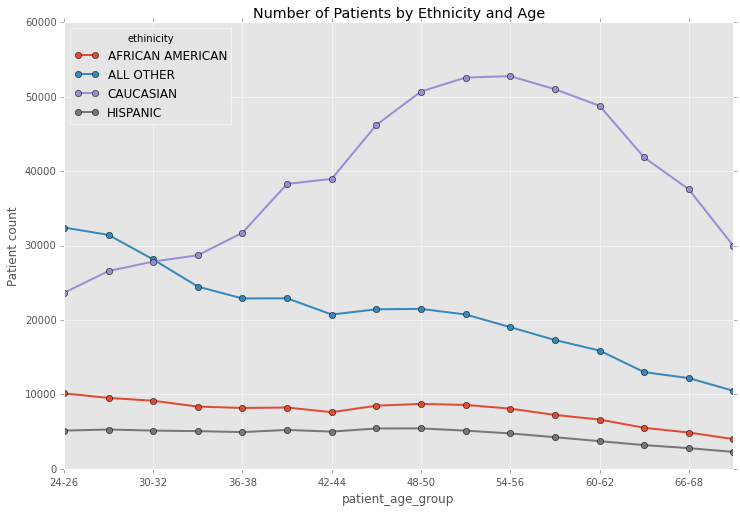

In [14]:
ax = train.groupby(['ethinicity','patient_age_group']).count().is_screener.unstack().T.plot(lw=2, marker='o')
ax.set_ylabel('Patient count')
ax.set_title('Number of Patients by Ethnicity and Age')
plt.show()

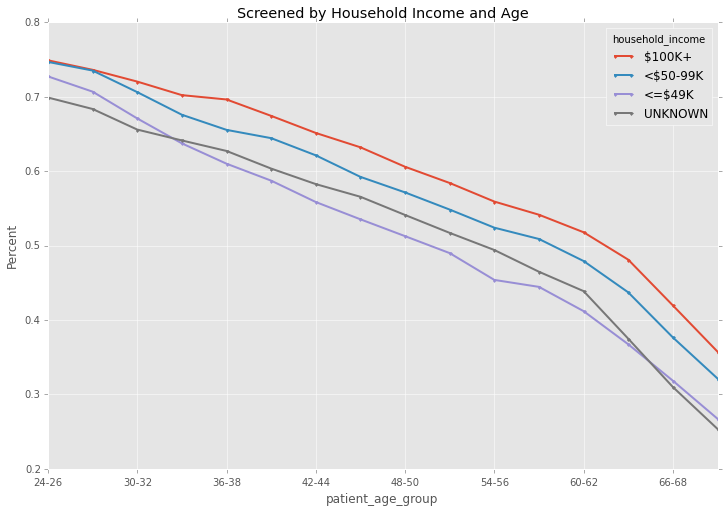

In [15]:
df = train.groupby(['household_income', 'patient_age_group']).is_screener.mean()
ax = df.unstack().T.plot(lw=2, marker='.')
ax.set_ylabel('Percent')
ax.set_title('Screened by Household Income and Age')
plt.show()

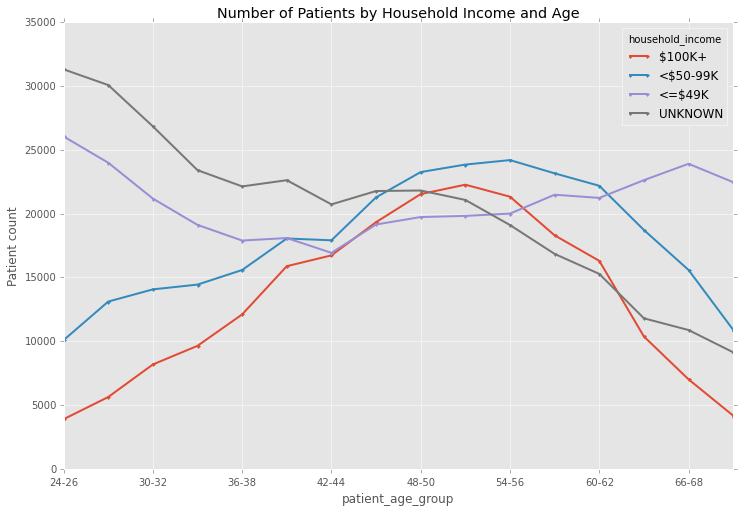

In [16]:
df = train.groupby(['household_income', 'patient_age_group']).is_screener.count()
ax = df.unstack().T.plot(linewidth=2, marker='.')
ax.set_ylabel('Patient count')
ax.set_title('Number of Patients by Household Income and Age')
plt.show()

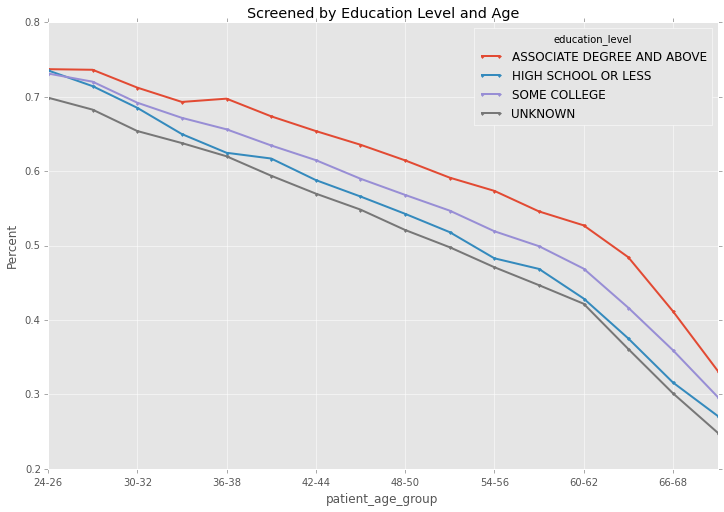

In [17]:
df = train.groupby(['education_level','patient_age_group']).is_screener.mean()
ax = df.unstack().T.plot(lw=2, marker='.')
ax.set_ylabel('Percent')
ax.set_title('Screened by Education Level and Age')
plt.show()

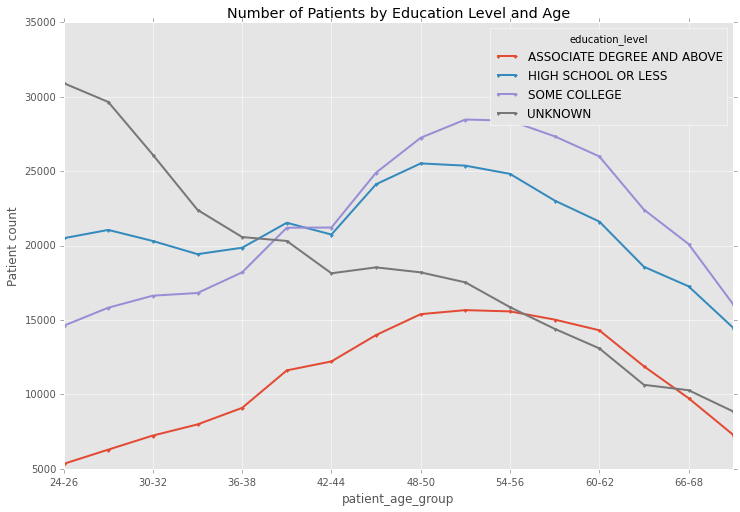

In [18]:
df = train.groupby(['education_level', 'patient_age_group']).is_screener.count()
ax = df.unstack().T.plot(linewidth=2, marker='.')
ax.set_ylabel('Patient count')
ax.set_title('Number of Patients by Education Level and Age')
plt.show()

## Screening by Diagnosis

The data has patient demographic information, and diagnosis, procedures and surgeries for each patient.  A diagnosis precedes any procedure or surgery, and we can identify which diagnosis are more predictive of screening patients.  In our [model](https://github.com/paulperry/kaggle-cervical-cancer-screening/wiki) we performed an L1 Lasso regression for all diagnosis with [VW](https://github.com/JohnLangford/vowpal_wabbit/wiki) and have a ranking of importance for each diagnosis that has a support of more than 100 patients. Here we list the top 20:

In [19]:
top_diagnosis = pd.read_csv('./features/diagnosis/diagnosis_varinfo.csv')
top_diagnosis.set_index('FeatureName', inplace=True)
diagnosis_code = pd.read_sql_query('select * from diagnosis_code;', db)
diagnosis_code.set_index('diagnosis_code', inplace=True)
top_diagnosis = top_diagnosis.merge(diagnosis_code, left_index=True, right_index=True, how='left')
top_diagnosis = top_diagnosis[top_diagnosis.MaxVal > 100] # drop the low count diagnosis
top_diagnosis = top_diagnosis.sort_values(by='RelScore', ascending=False)
top_diagnosis[:20]

,HashVal,MinVal,MaxVal,Weight,RelScore,diagnosis_description
FeatureName,,,,,,
200.52,34931848,0,107,+0.4335,35.34,"PRIMARY CENTRAL NERVOUS SYSTEM LYMPHOMA, INTRA..."
952.17,107180186,0,158,+0.2046,16.68,T7-T12 LEVEL WITH ANTERIOR CORD SYNDROME
E819.4,69246957,0,109,+0.0719,5.86,MOTOR VEHICLE TRAFFIC ACCIDENT OF UNSPECIFIED ...
V70.0,28629103,0,150,+0.0480,3.91,ROUTINE GENERAL MEDICAL EXAMINATION AT A HEALT...
V72.69,7517362,0,146,+0.0381,3.11,OTHER LABORATORY EXAMINATION
627.3,12063493,0,114,+0.0341,2.78,POSTMENOPAUSAL ATROPHIC VAGINITIS
533.30,22307620,0,141,+0.0334,2.72,ACUTE PEPTIC ULCER OF UNSPECIFIED SITE WITHOUT...
339.41,90070467,0,129,+0.0284,2.31,HEMICRANIA CONTINUA
V70.9,17974393,0,181,+0.0251,2.04,UNSPECIFIED GENERAL MEDICAL EXAMINATION


And the bottom 20:

In [20]:
top_diagnosis[-20:]

,HashVal,MinVal,MaxVal,Weight,RelScore,diagnosis_description
FeatureName,,,,,,
786.4,27883072,0,115,-0.0138,-1.13,ABNORMAL SPUTUM
V07.4,10871442,0,122,-0.0150,-1.22,HORMONE REPLACEMENT THERAPY (POSTMENOPAUSAL)
751.69,14358211,0,124,-0.0155,-1.27,"OTHER CONGENITAL ANOMALIES OF GALLBLADDER, BIL..."
478.33,18712882,0,103,-0.0159,-1.29,PARTIAL BILATERAL PARALYSIS OF VOCAL CORDS
349.9,127345017,0,129,-0.0160,-1.30,UNSPECIFIED DISORDERS OF NERVOUS SYSTEM
346.93,51552015,0,146,-0.0165,-1.34,"MIGRAINE, UNSPECIFIED, WITH INTRACTABLE MIGRAI..."
172.2,67795698,0,117,-0.0170,-1.39,MALIGNANT MELANOMA OF SKIN OF EAR AND EXTERNAL...
V66.0,99523275,0,157,-0.0179,-1.46,CONVALESCENCE FOLLOWING SURGERY
797,20109692,0,218,-0.0180,-1.47,SENILITY WITHOUT MENTION OF PSYCHOSIS


If we look at all diagnosis and rank by count descenging:

In [21]:
# diagnosis_counts = pd.read_sql_query('select diagnosis_code, count(distinct patient_id) count from diangosis \
#     group by diagnosis_code having count(distinct patient_id) > 100 order by count desc', db)

diagnosis_counts = pd.read_csv('./features/diagnosis/diagnosis_counts.csv')

In [22]:
diagnosis_counts.set_index('diagnosis_code', inplace=True)
diagnosis_counts.sort_values(by='count', ascending=False, inplace=True)
diagnosis_counts = diagnosis_counts.merge(diagnosis_code, left_index=True, right_index=True, how='left')
diagnosis_counts[:20]

,count,diagnosis_description
diagnosis_code,,
V72.31,1603813,ROUTINE GYNECOLOGICAL EXAMINATION
V76.12,1575791,OTHER SCREENING MAMMOGRAM
401.9,1258095,UNSPECIFIED ESSENTIAL HYPERTENSION
729.5,1192658,PAIN IN LIMB
780.79,1167895,OTHER MALAISE AND FATIGUE
V70.0,1167207,ROUTINE GENERAL MEDICAL EXAMINATION AT A HEALT...
789.00,1136609,"ABDOMINAL PAIN, UNSPECIFIED SITE"
272.4,1124718,OTHER AND UNSPECIFIED HYPERLIPIDEMIA
786.50,1079385,UNSPECIFIED CHEST PAIN


We notice that the most common diagnosis_code's are V7* codes, routine exams of one kind or another. 

The **insight** is that these diagnosis can be grouped into:
1. diagnosis relating to routine or gynecological exams (V70.0, V7*.*, V72.31, etc)
- pregnancy (V22.2, V22.)
- gynecologyical (626.4, 616.10)
- or desease or severe injury (cancer, 200.52, 230.4, 172.2, 173.10, etc.) sometimes associated with age (797)

We examine each of these diagnosis groupings.

## Interaction with the Medical System: Patient had a Medical Exam

A number of features are a proxy for patient's level of interaction with the medical system.  In our model, the number of visits (a count from the patient_activity table), or num_procedures (count of all procedures performed), are highly ranked features in an XGBoost model. 

A key entry point to the medical system is an annual medical exam.  We look at whether the patient has ever had medical exam ( diagnosis_code in ('V70', 'V70.0', 'V70.1', 'V70.2', 'V70.3', 'V70.4', 'V70.5', 'V70.6', 'V70.7', 'V70.8', 'V70.9'), and calculate the likelihood of screening for the patient.

In [23]:
# medical_exam = pd.read_sql_query("select * from diagnosis where diagnosis_code in \
#     ('V70', 'V70.0', 'V70.1', 'V70.2', 'V70.3', 'V70.4', 'V70.5', 'V70.6', 'V70.7', 'V70.8', 'V70.9' ) \
#     and patient_id in (select patient_id from patients_train );", db)

In [32]:
# cached version of the query above
medical_exam = pd.read_csv('./features/train_medical_exam.csv')

There are 1,157,817 patients in the train set, of which, 498,157 have had a medical exam during the entire 7 years of the data.  

In [25]:
medical_exam.drop_duplicates('patient_id', inplace=True)
medical_exam.shape[0]

498157

So less than half of the population has had a regular medical exam:

In [26]:
medical_exam.shape[0] / float(train.shape[0])

0.43025538578203637

But the average screening rate is 66% for patients who have had any medical exam:

In [27]:
train.loc[medical_exam.patient_id].is_screener.mean()

0.668441876757729

And only 47% if they never have had one:

In [28]:
train.loc[~train.index.isin(medical_exam.patient_id)].is_screener.mean()

0.4742200527544493

## Patient was referred to a Gynecological Exam

If the patient had one of these codes, then they may have been referred to a gynecological exam:
```
 diagnosis_code |  diagnosis_description                                                 
----------------+-----------------------------------
 V72.3          | GYNECOLOGICAL EXAMINATION
 V72.31         | ROUTINE GYNECOLOGICAL EXAMINATION
```

In [30]:
# gyn_exam = pd.read_sql_query("select t1.patient_id, claim_type, diagnosis_date, diagnosis_code from diagnosis t1 \
#                              right join patients_train t2 on (t1.patient_id=t2.patient_id ) \
#                              where diagnosis_code in ('V72.3', 'V72.31');", db)

In [33]:
# cached version of the query above
gyn_exam = pd.read_csv('./features/train_gyn_exam.csv')

In [34]:
gyn_exam[:5]

,patient_id,claim_type,diagnosis_date,diagnosis_code
0,112956268,MX,201310,V72.31
1,183576058,MX,201310,V72.31
2,187476589,MX,201310,V72.31
3,163205483,MX,201310,V72.31
4,170954263,MX,201310,V72.31


In [35]:
gyn_exam.drop_duplicates('patient_id', inplace=True)
gyn_exam.shape[0]

648737

More than half the patients in this database have had a gynecological exam:

In [36]:
gyn_exam.shape[0] / float(train.shape[0])

0.5603104808445549

And if they have had an exam then the likelihood that they have been screened is high:

In [37]:
train.loc[gyn_exam.patient_id].is_screener.mean()

0.8079591575630802

And quite low if they have not had a gynecological exam:

In [38]:
no_gyn_exam = train.loc[~train.index.isin(gyn_exam.patient_id)]
no_gyn_exam.is_screener.mean()

0.23898012100259292

We can look at the screening precentage and absolute patient counts for patients that have had a medical exam and/or a gynecological exam

In [39]:
medical_and_gyn_exam_df = train.loc[medical_exam.loc[medical_exam.patient_id.isin(gyn_exam.patient_id)].patient_id]
medical_and_gyn_exam = medical_and_gyn_exam_df.is_screener.mean()

medical_and_no_gyn_exam_ids = set(medical_exam.patient_id) - set(gyn_exam.patient_id) 
medical_and_no_gyn_exam = train.loc[medical_and_no_gyn_exam_ids].is_screener.mean()

no_medical_and_gyn_exam_ids = set(gyn_exam.patient_id) - set(medical_exam.patient_id)
no_medical_and_gyn_exam = train.loc[no_medical_and_gyn_exam_ids].is_screener.mean()

no_medical_and_no_gyn_exam_ids = set(train.index) - (set(medical_exam.patient_id) | set(gyn_exam.patient_id))
no_medical_and_no_gyn_exam = train.loc[no_medical_and_no_gyn_exam_ids].is_screener.mean()

In [40]:
mat = [[medical_and_gyn_exam, medical_and_no_gyn_exam], [no_medical_and_gyn_exam, no_medical_and_no_gyn_exam]]

In [41]:
engaged_pct = pd.DataFrame(mat, index=['Medical Exam', 'No Medical Exam'], columns=['Gyn Exam', 'No Gyn Exam'])
engaged_pct

,Gyn Exam,No Gyn Exam
Medical Exam,0.857353,0.336702
No Medical Exam,0.782578,0.192350


In [43]:
mat_cnt = [[len(medical_and_gyn_exam_df), len(medical_and_no_gyn_exam_ids)], 
           [len(no_medical_and_gyn_exam_ids), len(no_medical_and_no_gyn_exam_ids)]]
engaged_cnt = pd.DataFrame(mat_cnt, index=['Medical Exam', 'No Medical Exam'], columns=['Gyn Exam', 'No Gyn Exam'])
engaged_cnt

,Gyn Exam,No Gyn Exam
Medical Exam,1104455,164448
No Medical Exam,315028,344632


In [44]:
# Pick a colormap
# I'd like to set alpha=0.2 , but haven't figured it out yet
cmap='RdYlGn'

Looking at  each of the demographics separately, at the aggregate level, for the patients that 
did **not** have a medical exam or a gynecological exam, we don't see any trends other than younger patients are more likely to be screened:

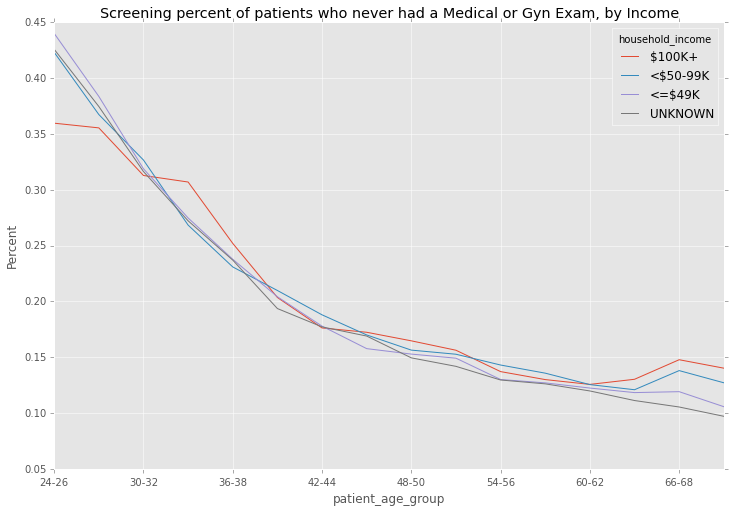

In [51]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'household_income']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who never had a Medical or Gyn Exam, by Income')
ax.set_ylabel('Percent')
plt.show()

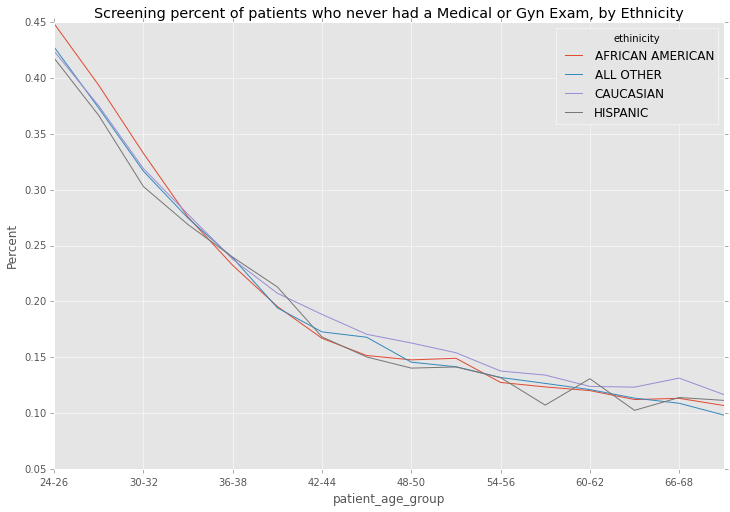

In [53]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'ethinicity']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who never had a Medical or Gyn Exam, by Ethnicity')
ax.set_ylabel('Percent')
plt.show()

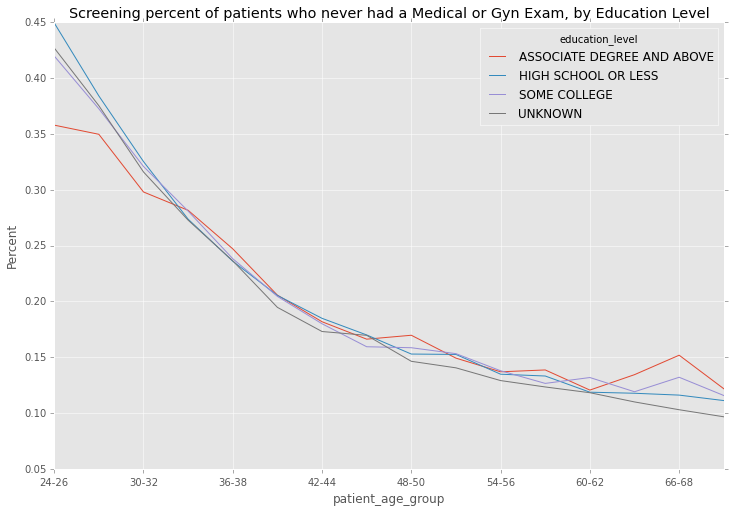

In [54]:
df = train.loc[no_medical_and_no_gyn_exam_ids].groupby(['patient_age_group',
                                                        'education_level']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who never had a Medical or Gyn Exam, by Education Level')
ax.set_ylabel('Percent')
plt.show()

## Where are the patients that have never had a medical exam?

In [83]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from matplotlib.collections import PatchCollection
import geopandas as gpd
print('geopandas: '+gpd.__version__)

geopandas: 0.1.0.dev-


In [84]:
# settings  
plt.rcParams['figure.figsize']=(16,14) 

In [85]:
# US Bounding box
minx, miny, maxx, maxy = -125,22,-65,50  # USA bounding box
usbbox = Polygon([(minx,miny),(minx,maxy),(maxx, maxy),(maxx,miny)])

In [68]:
train_cbsa = pd.read_csv('./features/train_patient_cbsa.csv.gz')
train_cbsa.set_index('patient_id', inplace=True)

In [71]:
train_cbsa.iloc[:5]

,cbsa,num_visits
patient_id,,
84548607,46340,17
84548626,23900,7
84548666,21700,3
84548805,31080,19
84548821,35620,9


In [72]:
train_full = train.merge(train_cbsa, left_index=True, right_index=True, how='left')

In [77]:
train_full.loc[no_medical_and_no_gyn_exam_ids].iloc[:5]

,patient_age_group,patient_state,ethinicity,household_income,education_level,is_screener,cbsa,num_visits
patient_id,,,,,,,,
165659732,63-65,SC,AFRICAN AMERICAN,<=$49K,SOME COLLEGE,0,17900,11
106954753,66-68,OR,CAUCASIAN,<$50-99K,SOME COLLEGE,0,38900,18
206869933,39-41,PA,CAUCASIAN,<=$49K,HIGH SCHOOL OR LESS,0,14100,8
154140677,45-47,TX,AFRICAN AMERICAN,<=$49K,HIGH SCHOOL OR LESS,0,26420,7
197132295,27-29,FL,HISPANIC,<=$49K,HIGH SCHOOL OR LESS,0,36740,14


In [126]:
cbsa_screen_of_no_exams = train_full.loc[no_medical_and_no_gyn_exam_ids].groupby('cbsa').is_screener.mean()
cbsa_screen_of_no_exams = cbsa_screen_of_no_exams.to_frame()

In [127]:
cbsa_screen_of_no_exams = pd.merge(cbsa, cbsa_screen_of_no_exams, left_index=True, right_index=True, how='left')

In [135]:
cbsa_screen_of_no_exams.sort_values(by='is_screener', inplace=True)
cbsa_screen_of_no_exams[cbsa_screen_of_no_exams.is_screener > 0][['NAME','is_screener']].iloc[:10]

,NAME,is_screener
GEOID,,
22520,"Florence-Muscle Shoals, AL",0.026480
47220,"Vineland-Bridgeton, NJ",0.027778
13980,"Blacksburg-Christiansburg-Radford, VA",0.029412
17340,"Clearlake, CA",0.033333
40080,"Richmond-Berea, KY",0.037037
22700,"Fort Dodge, IA",0.041667
20940,"El Centro, CA",0.041667
26540,"Huntington, IN",0.043478
43300,"Sherman-Denison, TX",0.048780


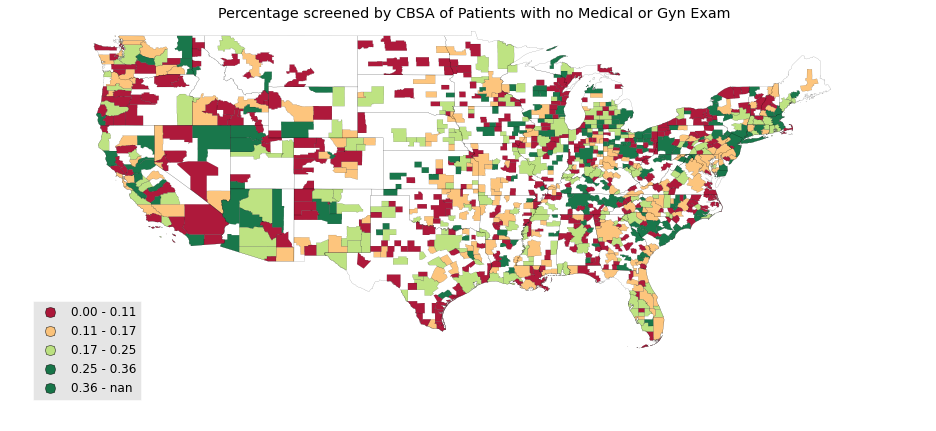

In [131]:
cbsa = cbsa[cbsa.geometry.within(usbbox)]
ax = states_map.plot(column=None, color='white', linewidth=0.1)
ax = cbsa_screen_of_no_exams.plot(column='is_screener', scheme='QUANTILES', k=5, colormap='RdYlGn', 
               alpha=0.9, ax=ax, linewidth=0.1, legend=True)
ax.axis('off')
plt.title('Percentage screened by CBSA of Patients with no Medical or Gyn Exam')
plt.show()

## Patient was pregnant or related

Our models showed the following diagnosis were strong predictors of being screened:
- 646.83 	OTHER SPECIFIED ANTEPARTUM COMPLICATIONS		
- 648.93 	OTHER CURRENT CONDITIONS CLASSIFIABLE ELSEWHERE OF MOTHER, ANTEPARTUM		
- 650	    NORMAL DELIVERY		
- V22.0 	SUPERVISION OF NORMAL FIRST PREGNANCY
- V22.1 	SUPERVISION OF OTHER NORMAL PREGNANCY
- V22.2 	PREGNANT STATE, INCIDENTAL
- V24.2 	ROUTINE POSTPARTUM FOLLOW-UP
- V25.2 	STERILIZATION
- V27.0 	MOTHER WITH SINGLE LIVEBORN
- V28.3 	ENCOUNTER FOR ROUTINE SCREENING FOR MALFORMATION USING ULTRASONICS
- V74.5 	SCREENING EXAMINATION FOR VENEREAL DISEASE

In [ ]:
# pregnancy = pd.read_sql_query("select t1.patient_id, claim_type, diagnosis_date, diagnosis_code from diagnosis t1 \
#                              right join patients_train t2 on (t1.patient_id=t2.patient_id) where diagnosis_code in \
#                              ('V22.0','V22.1','V22.2','V24.2','V25.2','V27.0','V28.3','V70.0','V74.5');", db)
# pregnancy.shape

In [142]:
# cached version of query above
pregnancy = pd.read_csv('./features/train_pregnant.csv')

In [143]:
pregnancy.drop_duplicates('patient_id', inplace=True)
pregnancy.shape

(627113, 4)

Patients that had one of the above diagnosis were screened with the following likelihood:

In [144]:
train.loc[pregnancy.patient_id].is_screener.mean()

0.6839947505473495

And those that were not:

In [145]:
train.loc[~train.index.isin(pregnancy.patient_id)].is_screener.mean()

0.40864775844915435

Looking at these pregnancy diagnosis by demographics:

In [148]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

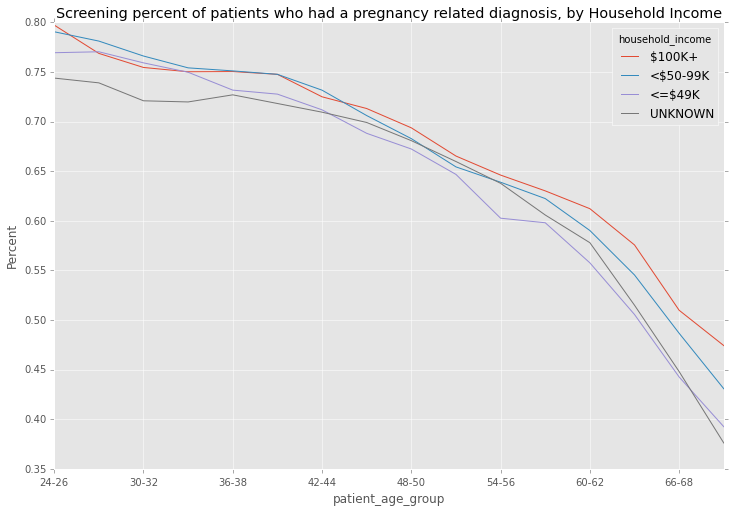

In [149]:
df = train.loc[pregnancy.patient_id].groupby(['patient_age_group',
                                              'household_income']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who had a pregnancy related diagnosis, by Household Income')
ax.set_ylabel('Percent')
plt.show()

Versus the patients who has no such diagnosis:

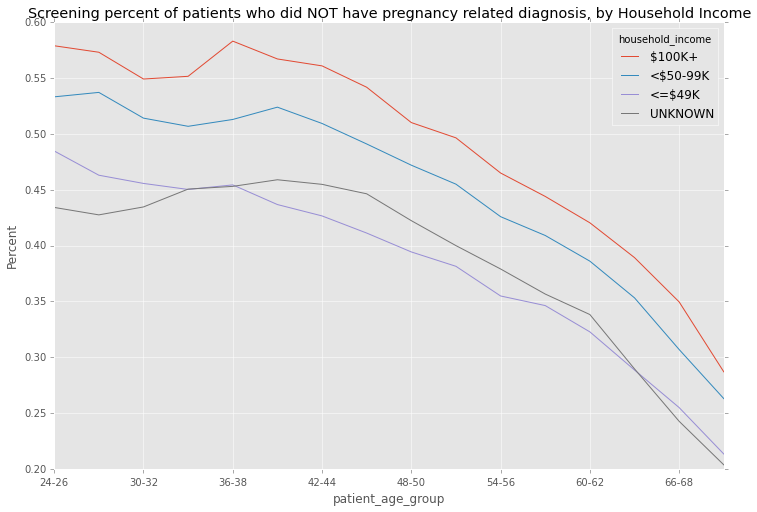

In [150]:
df = train.loc[~train.index.isin(pregnancy.patient_id)].groupby(['patient_age_group',
                                              'household_income']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who did NOT have pregnancy related diagnosis, by Household Income')
ax.set_ylabel('Percent')
plt.show()

Again, by ethnicity, for patients that had such diagnosis:

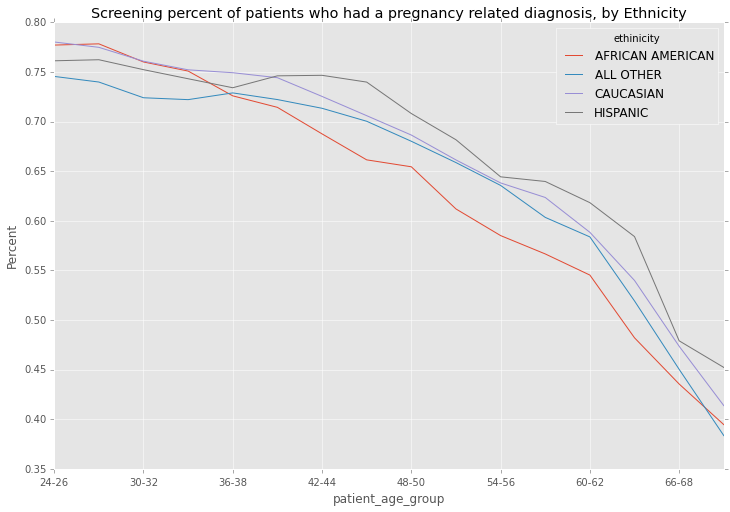

In [151]:
df = train.loc[pregnancy.patient_id].groupby(['patient_age_group',
                                              'ethinicity']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who had a pregnancy related diagnosis, by Ethnicity')
ax.set_ylabel('Percent')
plt.show()

And those patients that had no such diagnosis:

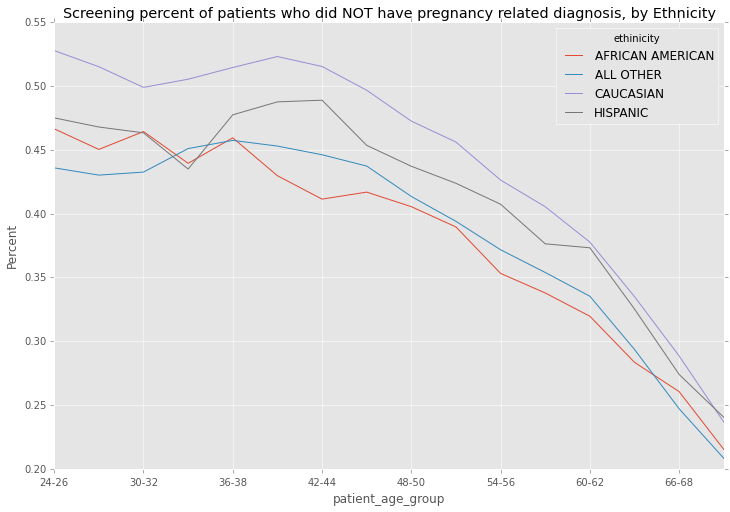

In [152]:
df = train.loc[~train.index.isin(pregnancy.patient_id)].groupby(['patient_age_group',
                                              'ethinicity']).is_screener.mean().unstack()
ax = df.plot(title='Screening percent of patients who did NOT have pregnancy related diagnosis, by Ethnicity')
ax.set_ylabel('Percent')
plt.show()

## Patient has other highly predictive diagnosis

Our modelling revealed the following diagnosis were also highly predictive of screening, and the same analysis as above could be performed, but these diagnosis look like the patient is already down a path that required that they be screened, but we are looking for patients that are not being screened.

- 462	ACUTE PHARYNGITIS		
- 496	CHRONIC AIRWAY OBSTRUCTION, NOT ELSEWHERE CLASSIFIED		
- 585.3	CHRONIC KIDNEY DISEASE, STAGE III (MODERATE)		
- 616	CERVICITIS AND ENDOCERVICITIS		
- 616.1	VAGINITIS AND VULVOVAGINITIS, UNSPECIFIED		
- 620.2	OTHER AND UNSPECIFIED OVARIAN CYST		
- 622.1	DYSPLASIA OF CERVIX, UNSPECIFIED		
- 622.11	MILD DYSPLASIA OF CERVIX		
- 623.5	LEUKORRHEA, NOT SPECIFIED AS INFECTIVE		
- 625.3	DYSMENORRHEA		
- 625.9	UNSPECIFIED SYMPTOM ASSOCIATED WITH FEMALE GENITAL ORGANS		
- 626	ABSENCE OF MENSTRUATION		
- 626.2	EXCESSIVE OR FREQUENT MENSTRUATION		
- 626.4	IRREGULAR MENSTRUAL CYCLE		
- 626.8	OTHER DISORDERS OF MENSTRUATION AND OTHER ABNORMAL BLEEDING FROM FEMALE GENITAL				
- 795	ABNORMAL GLANDULAR PAPANICOLAOU SMEAR OF CERVIX		

## Patient had procedures predictive of not being screened

We found the following procedures positively correlated with a patient being screened:

```
procedure_code   procedure_description                            RelScore
57454            COLPOSCOPY CERVIX BX CERVIX & ENDOCRV CURRETAGE   100.00%
1252             GJB2 GENE ANALYSIS FULL GENE SEQUENCE              96.93%
57456            COLPOSCOPY CERVIX ENDOCERVICAL CURETTAGE           95.00%
57455            COLPOSCOPY CERVIX UPPR/ADJCNT VAGINA W/CERVIX BX   91.42%
S4020            IN VITRO FERTILIZATION PROCEDURE CANCELLED BEFOR   85.76%
S0605            DIGITAL RECTAL EXAMINATION, MALE, ANNUAL           83.64%
G0143            SCREENING CYTOPATHOLOGY, CERVICAL OR VAGINAL (AN   78.39%
90696            DTAP-IPV VACCINE CHILD 4-6 YRS FOR IM USE          76.98%
S4023            DONOR EGG CYCLE, INCOMPLETE, CASE RATE             76.67%
69710            IMPLTJ/RPLCMT EMGNT BONE CNDJ DEV TEMPORAL BONE    72.06%
```

and the following procedures negatively correlated:

```
procedure_code        procedure_description             RelScore
K0735  SKIN PROTECTION WHEELCHAIR SEAT CUSHION, ADJUSTA  -62.48%
34805  EVASC RPR AAA AORTO-UNIILIAC/AORTO-UNIFEM PROSTH  -64.68%
L5975  ALL LOWER EXTREMITY PROSTHESIS, COMBINATION SING  -65.39%
89321  SEMEN ANALYSIS SPERM PRESENCE&/MOTILITY SPRM      -65.51%
S9145  INSULIN PUMP INITIATION, INSTRUCTION IN INITIAL   -69.96%
00632  ANESTHESIA LUMBAR REGION LUMBAR SYMPATHECTOMY     -77.13%
27756  PRQ SKELETAL FIXATION TIBIAL SHAFT FRACTURE       -78.61%
3303F  AJCC CANCER STAGE IA, DOCUMENTED (ONC), (ML)      -82.77%
23675  CLTX SHOULDER DISLC W/SURG/ANTMCL NECK FX W/MANJ  -83.14%
Q4111  GAMMAGRAFT, PER SQUARE CENTIMETER                 -85.49%
```

It seems clear that a number of negatively correlated procedures identify patients that have bigger problems than the need for a cervical exam, and it is possible physicians have not recommended a screening for these reasons.  Therefore the analysis above should be rerun without these patients skewing the likelihood percentages.

## Where are the patients ?

We can review all slices of screener likelihoods by geography.

In [153]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from matplotlib.collections import PatchCollection
import geopandas as gpd
print('geopandas: '+gpd.__version__)

geopandas: 0.1.0.dev-


In [154]:
# settings  
plt.rcParams['figure.figsize']=(16,14) 

In [155]:
# US Bounding box
minx, miny, maxx, maxy = -125,22,-65,50  # USA bounding box
usbbox = Polygon([(minx,miny),(minx,maxy),(maxx, maxy),(maxx,miny)])

## Map States

Looking at the likelyhood by state:

In [156]:
# We grabbed the USA shape files from : https://github.com/matplotlib/basemap/tree/master/examples
# or state files from here: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html
# We took the CBSA files from https://www.census.gov/geo/maps-data/data/cbf/cbf_msa.html

In [157]:
state_pct = pd.read_csv('./features/state_screen_percent.csv')
state_pct.set_index('patient_state', inplace=True)
state_pct[:5]

,state_pct
patient_state,
AK,0.496903
AL,0.417596
AR,0.437814
AZ,0.504682
CA,0.526563


In [158]:
states_key = pd.read_csv('./datastudy/state.csv')
states_key.set_index('name_long', inplace=True)
states_key[:5]

,name_short
name_long,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


In [159]:
state_file = './datastudy/st99_d00.shp'
#bbox=(-119,22,64,49)
bbox=(-125,22,-65,50)
kw = dict(bbox=bbox)
states_map = gpd.GeoDataFrame.from_file(state_file, **kw)

#state_file = 'cb_2014_us_state_500k.shp'
# states = gpd.GeoDataFrame.from_file(state_file)

if gpd.__version__ != '0.1.0.dev-':  # temp fix 
    states_map.geometry = convert_3D_2D(states.geometry)

In [160]:
states_map[:2]

,AREA,DIVISION,LSAD,LSAD_TRANS,NAME,PERIMETER,REGION,ST99_D00_,ST99_D00_I,STATE,geometry
0,271.254384,9,01,None,Alaska,227.171422,4,2,1,02,POLYGON ((-147.7871108843566 70.24536349411568...
1,0.003749,9,01,None,Alaska,0.349840,4,3,2,02,"POLYGON ((-166.053153 66.264944, -166.03187 66..."


In [161]:
states_map = states_map.merge(states_key, left_on='NAME', right_index=True, how='left')
states_map = states_map.merge(state_pct, left_on='name_short', right_index=True, how='left')

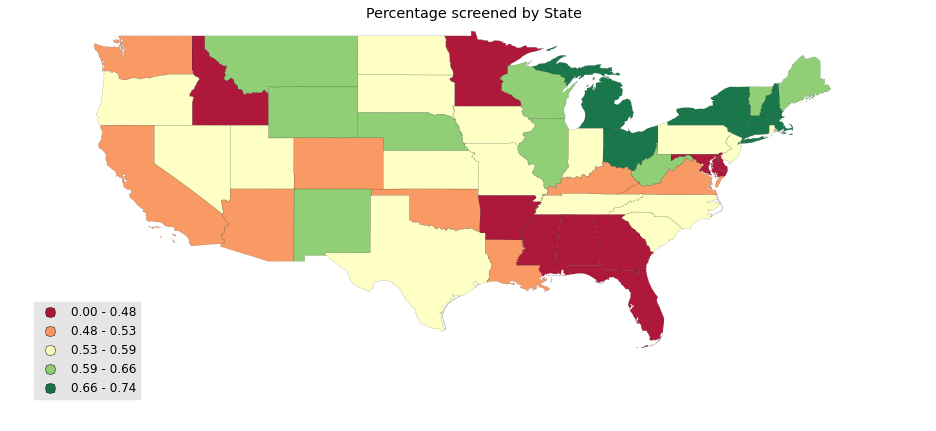

In [162]:
states_map = states_map[states_map.geometry.within(usbbox)]
# plt.figure(figsize=(12,10))
ax = states_map[states_map.state_pct.notnull()].plot(column='state_pct', scheme='QUANTILES', k=5, colormap='RdYlGn', 
                                             alpha=0.9, linewidth=0.1, legend=True)
ax.axis('off')
plt.title('Percentage screened by State')
plt.show()

## By CBSA

Every patient was mapped to the [CBSA](https://en.wikipedia.org/wiki/Core-based_statistical_area) where they had the most diagnosis.  We can then look at the likelihoods by these areas.  Combining this map as screened by the features above would render a better map for targeting patients who are not being screened.

In [163]:
cbsa_pct = pd.read_csv('./features/cbsa_pct.csv.gz')
cbsa_pct.set_index('cbsa', inplace=True)
cbsa_pct[:5]

,pct_screened
cbsa,
10100,0.528302
10140,0.312376
10180,0.301802
10220,0.591623
10300,0.681319


In [164]:
cbsa = gpd.GeoDataFrame.from_file('./datastudy/cb_2014_us_cbsa_500k.shp')
cbsa.GEOID = cbsa.GEOID.astype(float)
cbsa.set_index('GEOID', inplace=True)
cbsa.shape

(929, 8)

In [165]:
cbsa['pct_screened'] = cbsa_pct.pct_screened

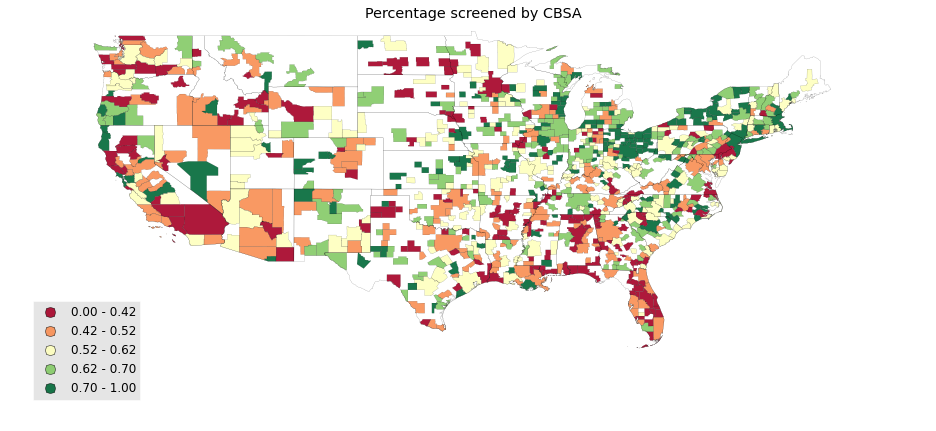

In [166]:
cbsa = cbsa[cbsa.geometry.within(usbbox)]
ax = states_map.plot(column=None, color='white', linewidth=0.1)
ax = cbsa[cbsa.pct_screened.notnull()].plot(column='pct_screened', scheme='QUANTILES', k=5, colormap='RdYlGn', 
               alpha=0.9, ax=ax, linewidth=0.1, legend=True)
ax.axis('off')
plt.title('Percentage screened by CBSA')
plt.show()

## Further Work

- The final goal is to remove the patients who are clearly to are sick or invalid and focus on the remaining healthy patients and rank the CBSA's where an outreach campaign would have the most impact.  We are close but ran out of time.
- There are many physicians performing a routine gynecological exam that have a `specialty_code` other than `OBG` or `GYN`.  Looking into these differences by geography might be interesting.
- We have started to look at the percentage of screening by the `primary_practitioner` referring or performing the GYN exam and there are some stark differences.  Understanding these differences will help target the physicians rather than the patients.